# Feature Engineering

In [1]:
conda install scikit-image

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.14.0
  latest version: 22.9.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [241]:
import pickle
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from skimage import data
from skimage.util import img_as_ubyte
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
import cv2

In [3]:
# Load Data

with open('X_test.pkl','rb') as f:
    X_test = pickle.load(f)
    print(len(X_test))

with open('y_test.pkl','rb') as f:
    y_test = pickle.load(f)
    print(len(y_test))
    
with open('X_train.pkl','rb') as f:
    X_train = pickle.load(f)
    print(len(X_train))
    
with open('y_train.pkl','rb') as f:
    y_train = pickle.load(f)
    print(len(y_train))

459
459
4119
4119


## Rescale Image

In [4]:
def Rescaler(X_array):
    xb = []
    for x in X_array:
        xb.append(resize(x, (128,64,3)))
    return xb

## Scale the test and train set pictures

In [5]:
X_train_scaled = Rescaler(X_train)

In [6]:
X_test_scaled = Rescaler(X_test)

In [7]:
#Verify that they are the correct length
print(len(X_train_scaled))
print(len(X_test_scaled))

4119
459


AxesImage(10.8,10.8;410.4x266.4)


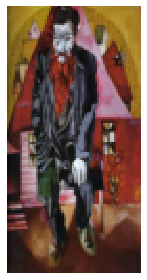

In [8]:
plt.axis("off")
print(imshow(X_train_scaled[4021]));

## Separate Image into 3 by its color channel

reshape into histogram

In [181]:
def ColorSplit(X_data):
    red = []
    green = []
    blue = []
       
    for x in X_data:
        #create variable for each array
        im = x
        
        #Red Image
        im_r = np.zeros(np.shape(im[:,:,0]))
        im_r = im[:, :, 0]
          
        #Green Image
        im_g = np.zeros(np.shape(im[:,:,0]))
        im_g = im[:, :, 1]
        
        #Blue Image
        im_b = np.zeros(np.shape(im[:,:,0]))
        im_b = im[:, :, 2]
        
        #Add to parent lists
        red.append(im_r) # Red channel
        green.append(im_g) # Green channel
        blue.append(im_b) # Blue channel
    
        
    return red, green, blue

In [179]:
red_train, green_train, blue_train = ColorSplit(X_train_scaled)

(128, 64, 3)
(128, 64)


In [188]:
blue_train[2].shape

(128, 64)

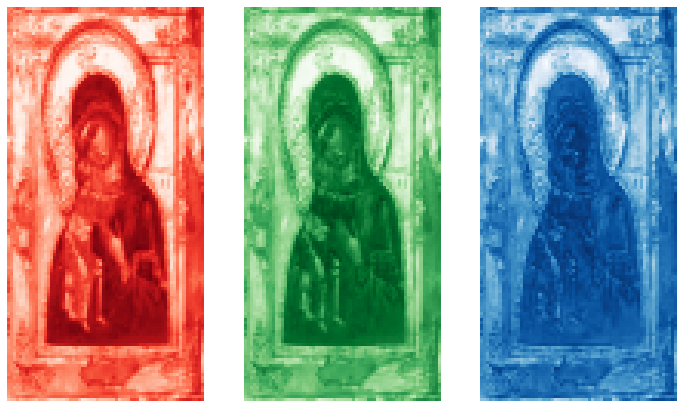

In [255]:
fig, ax = plt.subplots(1, 3, figsize=(12,8), sharey=True)
ax[0].imshow(red_train[0], cmap = 'Reds_r')
ax[0].axis('off') 
ax[1].imshow(green_train[0], cmap = 'Greens_r')
ax[1].axis('off')
ax[2].imshow(blue_train[0], cmap = 'Blues_r')
ax[2].axis('off');

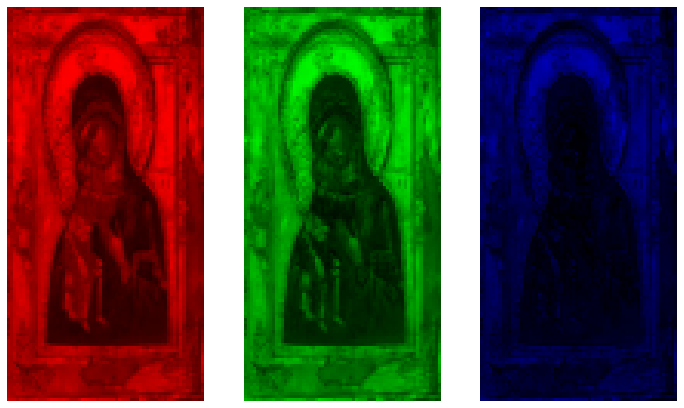

In [264]:
#Visualization using only one color channel at a time
ex = X_train_scaled[0]

im_r = np.zeros(np.shape(ex))
im_r[:, :, 0] = ex[:, :, 0]

im_g = np.zeros(np.shape(ex))
im_g[:, :, 1] = ex[:, :, 1]

im_b = np.zeros(np.shape(ex))
im_b[:, :, 2] = ex[:, :, 2]

fig, ax = plt.subplots(1, 3, figsize=(12,8), sharey=True)
ax[0].imshow(im_r)
ax[0].axis('off') 
ax[1].imshow(im_g)
ax[1].axis('off')
ax[2].imshow(im_b)
ax[2].axis('off');

## HOG (Histogram of Oriented Gradients)

In [12]:
def HOG_Feature(data_color):
    color_hog = []
    for x in data_color:
        fd = hog(x, orientations=9, pixels_per_cell=(8, 8), 
        cells_per_block=(2, 2), visualize=False, multichannel=True)
        color_hog.append(fd)
    return color_hog

In [13]:
red_hog = HOG_Feature(red_train)
green_hog = HOG_Feature(green_train)
blue_hog = HOG_Feature(blue_train)

In [14]:
print(len(red_hog))
print(len(green_hog))
print(len(blue_hog))

4119
4119
4119


(128, 64, 3)


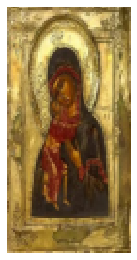

In [15]:
image_test = X_train_scaled[0]
imshow(image_test)
plt.axis("off")
print(image_test.shape)

In [16]:
fd = hog(image_test, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=False, multichannel=True)
print(fd, fd.shape)

[0.23592548 0.22063282 0.08722713 ... 0.01222817 0.12032402 0.22193548] (3780,)


[0.23592548 0.22063282 0.08722713 ... 0.01222817 0.12032402 0.22193548] (3780,)


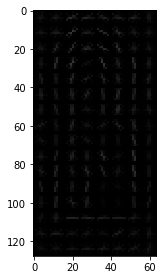

In [17]:
fd, hog_image = hog(image_test, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
print(fd, fd.shape)
imshow(hog_image)

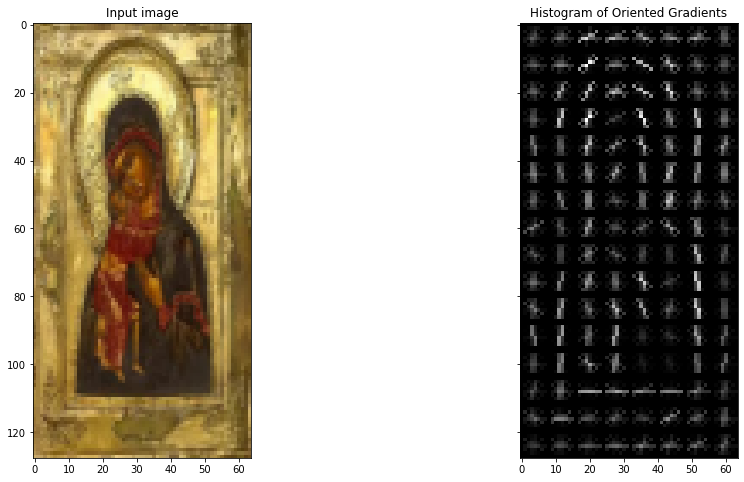

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 

ax1.imshow(image_test, cmap=plt.cm.gray) 
ax1.set_title('Input image') 

# Rescale histogram for better display 
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) 

ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
ax2.set_title('Histogram of Oriented Gradients')

plt.show()

### HOG Directional

In [19]:
import matplotlib.pylab as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage import filters

In [21]:
def SobelDerivatives(X):

    dx = []
    dy = []
    for x in X:
        im = rgb2gray(x)
        edges_x = filters.sobel_v(im)
        edges_y = filters.sobel_h(im)
        dx.append(edges_x)
        dy.append(edges_y)
    return dx, dy

In [22]:
dx_train, dy_train = SobelDerivatives(X_train_scaled)

In [23]:
dy_train[0]

array([[-0.00279373,  0.0120559 ,  0.12182312, ..., -0.03188036,
        -0.00260348,  0.00429158],
       [-0.02775821,  0.00789257,  0.06252475, ..., -0.06552427,
        -0.04109627, -0.0034369 ],
       [-0.05536888, -0.01686644, -0.00386805, ..., -0.03440247,
        -0.02481998,  0.05097924],
       ...,
       [ 0.04635539,  0.01782896, -0.0304985 , ...,  0.12671338,
         0.09173974, -0.01206777],
       [ 0.1348696 ,  0.13573569,  0.09029376, ...,  0.06657787,
         0.01976322, -0.02283568],
       [ 0.0936439 ,  0.11115601,  0.12059064, ..., -0.1187934 ,
        -0.12661559, -0.10529118]])

In [265]:
len(dy_train)

4119

Test Code:

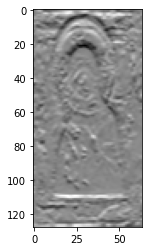

In [31]:
plt.imshow(dy_train[0]);

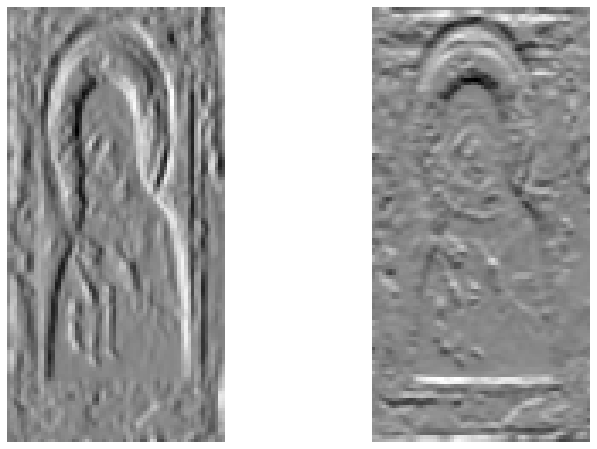

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12,8), sharey=True)
ax[0].imshow(dx_train[0])
ax[0].axis('off') 
ax[1].imshow(dy_train[0])
ax[1].axis('off');

## SIFT (Speeded-Up Robust Features)

In [28]:
pip install opencv-python==4.4.0.46

Note: you may need to restart the kernel to use updated packages.


In [ ]:
for pic in my_set:
    pic = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)
    kp, des = cv2.SIFT().detectAndCompute(pic, None)

Test Code

[[21. 19. 12. ...  0.  0.  0.]
 [27. 36. 30. ... 66. 17.  3.]
 [ 3.  4.  1. ...  1.  0.  0.]
 ...
 [89. 51.  0. ... 20.  6.  2.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  7.]]


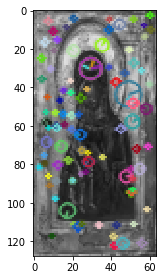

In [74]:
img = cv2.normalize(X_train_scaled[0], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
kp, des = sift.detectAndCompute(gray,None)
img=cv2.drawKeypoints(gray,kp,img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imshow(img)
print(des)

In [75]:
def SIFT(X):
    SIFT_list = []
    sift = cv2.SIFT_create()
    for x in X:
        img = cv2.normalize(x, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        kp, des = sift.detectAndCompute(gray,None)
        SIFT_list.append(des)
    return SIFT_list

In [77]:
X_train_SIFT = SIFT(X_train_scaled)

In [79]:
len(X_train_SIFT)

4119

## Entropy

In [81]:
import skimage.measure    


In [238]:
entropy = skimage.measure.shannon_entropy(X_train_scaled[0])
entropy

14.54867782015863

In [84]:
def Entropy(X):
    entropy_list = []
    for x in X:
        entropy_x = skimage.measure.shannon_entropy(x)
        entropy_list.append(entropy_x)
    return entropy_list

In [85]:
entropy_train = Entropy(X_train_scaled)

In [87]:
len(entropy_train)

4119

## Kurtosis

In [90]:
import scipy

In [228]:
#Check curtosis calculations on full color photographs
scipy.stats.kurtosis(X_train_scaled[0], axis = 0, fisher = True, bias = True)

array([[ 1.25411039,  2.36218728,  1.43458591],
       [ 0.35471975,  0.3166742 ,  0.47864059],
       [-0.44886666, -0.48903295,  0.50297795],
       [-0.98096436, -0.86770279, -0.51838756],
       [-0.83848888, -0.56820619, -0.13712727],
       [-1.00975949, -0.96728477, -0.72013013],
       [-0.41167519, -0.27035942, -0.3025793 ],
       [-0.71965042, -0.44183058,  0.87629214],
       [-0.1258264 , -0.11193988,  0.65885009],
       [-0.5074244 , -0.72109526, -0.51278051],
       [ 0.70559875,  0.35472842, -0.43557884],
       [ 0.00837188, -0.07466469,  0.07302197],
       [-0.64437899, -0.37919155,  1.50360224],
       [ 0.12237258, -0.07648845, -0.11346926],
       [-0.72882544, -0.91326581, -0.96181924],
       [-1.02758261, -1.01684699, -1.08445926],
       [-1.04060067, -0.9063871 , -0.47129281],
       [-1.11996229, -1.02742973, -0.78886367],
       [-1.14717561, -1.20881142, -0.98828475],
       [-0.61058566, -0.95097115, -0.60043666],
       [ 0.11666327, -0.37465637,  0.355

In [229]:
def Kurtosis(color_data):
    color_kurt = []
    for x in color_data:
        test = x.flatten()
        kurt = scipy.stats.kurtosis(test, axis = 0, fisher = True, bias = True)
        color_kurt.append(kurt)
    return color_kurt

In [232]:
red_train_kurt = Kurtosis(red_train)
green_train_kurt = Kurtosis(green_train)
blue_train_kurt = Kurtosis(blue_train)

In [234]:
len(green_train_kurt)

4119

## Skew

In [215]:
red_train[0].flatten()

array([0.61553309, 0.62695312, 0.54673713, ..., 0.43863358, 0.37263327,
       0.42817096])

In [221]:
#Test code
red_train_skew = []
for x in red_train:
    test = x.flatten()
    skew = scipy.stats.skew(test, axis = 0, bias = True)
    red_train_skew.append(skew)

In [219]:
def Skew(color_data):
    color_skew = []
    for x in color_data:
        test = x.flatten()
        skew = scipy.stats.skew(test, axis = 0, bias = True)
        color_skew.append(skew)
    return color_skew

In [223]:
# Create Skew Train Features
red_train_skew = Skew(red_train)
green_train_skew = Skew(green_train)
blue_train_skew = Skew(blue_train)

In [227]:
len(blue_train_skew)

4119

## Create Master Dataframe

In [305]:
array = np.array([dx_train, dy_train, X_train_SIFT, 
                  entropy_train, red_train_kurt, green_train_kurt, 
                  blue_train_kurt, red_train_skew, green_train_skew, blue_train_skew, y_train])

In [306]:
df = pd.DataFrame(data = array).T
df = df.rename(columns={0: 'X_HOG', 1: 'Y_HOG', 2: 'SIFT', 3: 'Entropy', 4: 'R Kurtosis', 5: 'G Kurtosis', 
                        6: 'B Kurtosis', 7: 'R Skew', 8: 'G Skew', 9: 'B Skew', 10: 'Y Class'})
df

,X_HOG,Y_HOG,SIFT,Entropy,R Kurtosis,G Kurtosis,B Kurtosis,R Skew,G Skew,B Skew,Y Class
0,"[[-0.010936565563725631, -0.03870453833486476,...","[[-0.002793731617641265, 0.012055895182294635,...","[[21.0, 19.0, 12.0, 124.0, 13.0, 0.0, 0.0, 3.0...",14.548678,-0.7654,-0.829706,-0.055504,-0.077586,0.128537,0.700668,0
1,"[[0.0, 0.0, 0.0, 0.0, 0.003921568627450828, 0....","[[-2.7755575615628914e-17, -2.7755575615628914...","[[7.0, 3.0, 0.0, 20.0, 57.0, 0.0, 0.0, 0.0, 16...",13.855987,-0.376967,-1.211892,-0.622112,-0.4318,-0.421352,0.475841,0
2,"[[-0.0032924786496633107, -0.00930581619562082...","[[-0.4787328757850756, -0.46881534687116455, -...","[[1.0, 30.0, 12.0, 7.0, 66.0, 30.0, 0.0, 0.0, ...",14.382859,-0.130683,0.263339,11.289003,-0.47108,0.528385,2.419452,0
3,"[[0.005286511445887109, 0.008965410180185658, ...","[[0.005286511445887109, 0.019272600217333673, ...","[[16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 179...",14.015892,-0.41605,-0.334552,0.509085,-0.018285,0.25116,0.814729,0
4,"[[-0.010440200099571126, -0.015998055683211006...","[[-0.02074370346966966, -0.025976669730392962,...","[[22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 152...",14.444224,-0.160634,0.194263,2.9793,0.373028,0.837173,1.497108,0
...,...,...,...,...,...,...,...,...,...,...,...
4114,"[[-0.004621325922947313, -0.004707035450654842...","[[0.025510436389399545, 0.02460817580279196, 0...","[[11.0, 1.0, 0.0, 0.0, 10.0, 22.0, 4.0, 11.0, ...",14.315582,-0.223491,-0.156018,-0.033907,0.882072,1.029305,1.182096,1
4115,"[[0.016039813112745438, 0.05078052954580316, 0...","[[-0.005720218769147779, -0.003895586511948261...","[[8.0, 0.0, 0.0, 0.0, 0.0, 12.0, 103.0, 130.0,...",14.196016,-0.718405,-0.776729,-0.766753,-0.048224,0.105136,0.325536,1
4116,"[[-0.0002593624518900037, 0.003152932027180768...","[[0.022629316747329466, 0.013486257402009011, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0,...",13.424913,2.313183,2.136825,5.10103,1.475956,1.392841,1.733968,1
4117,"[[-0.004647271273743897, -0.007777249827665478...","[[-0.00017583323759171043, 0.00663984173943021...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",13.777093,0.047465,0.538052,0.678428,1.080161,1.275035,1.314073,1


In [307]:
df.to_csv('painting_training_data.csv')  